In [15]:
%matplotlib inline
from scipy.integrate import odeint
from scipy.io import savemat, loadmat
import numpy as np
import  timeit
import  matplotlib.pyplot as plt
import  pandas as pd

M = 16  #Number of age-group
my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

#Ni= total population for age-group-i, N=Total population
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

######################### contact matrices###################################
#Home contact Matrix
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)
#Workspace Contact Matrix
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)
#School Conact Matrix
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)
#Others Contact Matrix
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)
CM = CH + CW + CS + CO

## Parameters and Initialization

In [16]:
alpha =  0.8       #0.0, 0.8 for ony symptomatic, and both symptomatic & asymptomatic
beta1 =  0.19      # contact rate parameter corresponds to Asymptomatic
beta2 =  0.19      # contact rate parameter corresponds to Symptomatic
epsln =  0.29      # recovery rate from E class
g_as  =  0.1       # recovery rate from A to I
rho_sd= 1/30       # recovery rate from I to D 
gIa   = 2./7       # recovery rate of asymptomatic infectives (2./7), and only symptomatic set gIa=0
gIs   = 1./7       # recovery rate of symptomatic infectives(1./7) 
fsa   = 0.1        # suppresion of contact by symptomatics(I)
par = 1.0          # 0.0=no asymptomatic, 1 = both asymptomatic and symptomatic

# initial conditions
E_0 = np.zeros((M))
Ia_0 = np.zeros((M))
Is_0 = np.zeros((M));  Is_0[6:13]=2;  Is_0[2:6]=1
R_0  = np.zeros((M))
D_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + E_0 + Is_0 + R_0 + D_0)

In [17]:
Tf = 300; Nf = 2001     #Tf -->final time from 0, Nf-->total number points
t = np.linspace(0,Tf,Nf)

In [18]:
def cont(t):
    return  CM
    #return CH  + u(t,0,200,t_won, t_woff, 0.8)*(CW + CO + CS)

   
 #S=y[i],    E=y[M+i], Ia=y[2M+i], Is=y[3M+i], R=y[4M+i],  for i=1,2,3,...,M

dy = np.zeros(5*M)
def rhs(y, t, cont):
    CM = cont(t)  #contact matrix
    for i in range(M):
        bb=0; cc=0
        for j in range(M):
            bb += beta1*(par*CM[i,j]*y[2*M+j])/Ni[j]
            cc += beta2*(fsa*CM[i,j]*y[3*M+j])/Ni[j]   
        aa = bb*y[i]; dd = cc*y[i]
        dy[i]     = -aa -dd    #Susceptibles
        dy[i+M]   =  aa + dd - epsln*y[M+i]  #Exposed  
        dy[i+2*M] =  alpha*epsln*y[M+i] - (g_as + gIa)*y[2*M+i]   #Asymptomatic
        dy[i+3*M] = (1-alpha)*epsln*y[M+i] + g_as*y[2*M+i]  - (rho_sd+gIs)*y[3*M+i]   #Symptomatic
        dy[i+4*M] = gIa*y[2*M+i] + gIs*y[3*M+i]  #Recovery
    return dy
        
data = odeint(rhs, np.concatenate((S_0, E_0, Ia_0, Is_0, R_0)), t, args=(cont,))
tempS, tempE,  tempIa, tempIs, tempR = np.zeros((Nf)),\
np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf)), np.zeros((Nf))
for i in range(M):
    tempS  += data[:, 0 * M + i]
    tempE  += data[:, 1 * M + i]
    tempIa += data[:, 2 * M + i]
    tempIs += data[:, 3 * M + i]
    tempR  += data[:, 4 * M + i]
IC_death = N - (tempS + tempE + tempIa + tempIs + tempR)

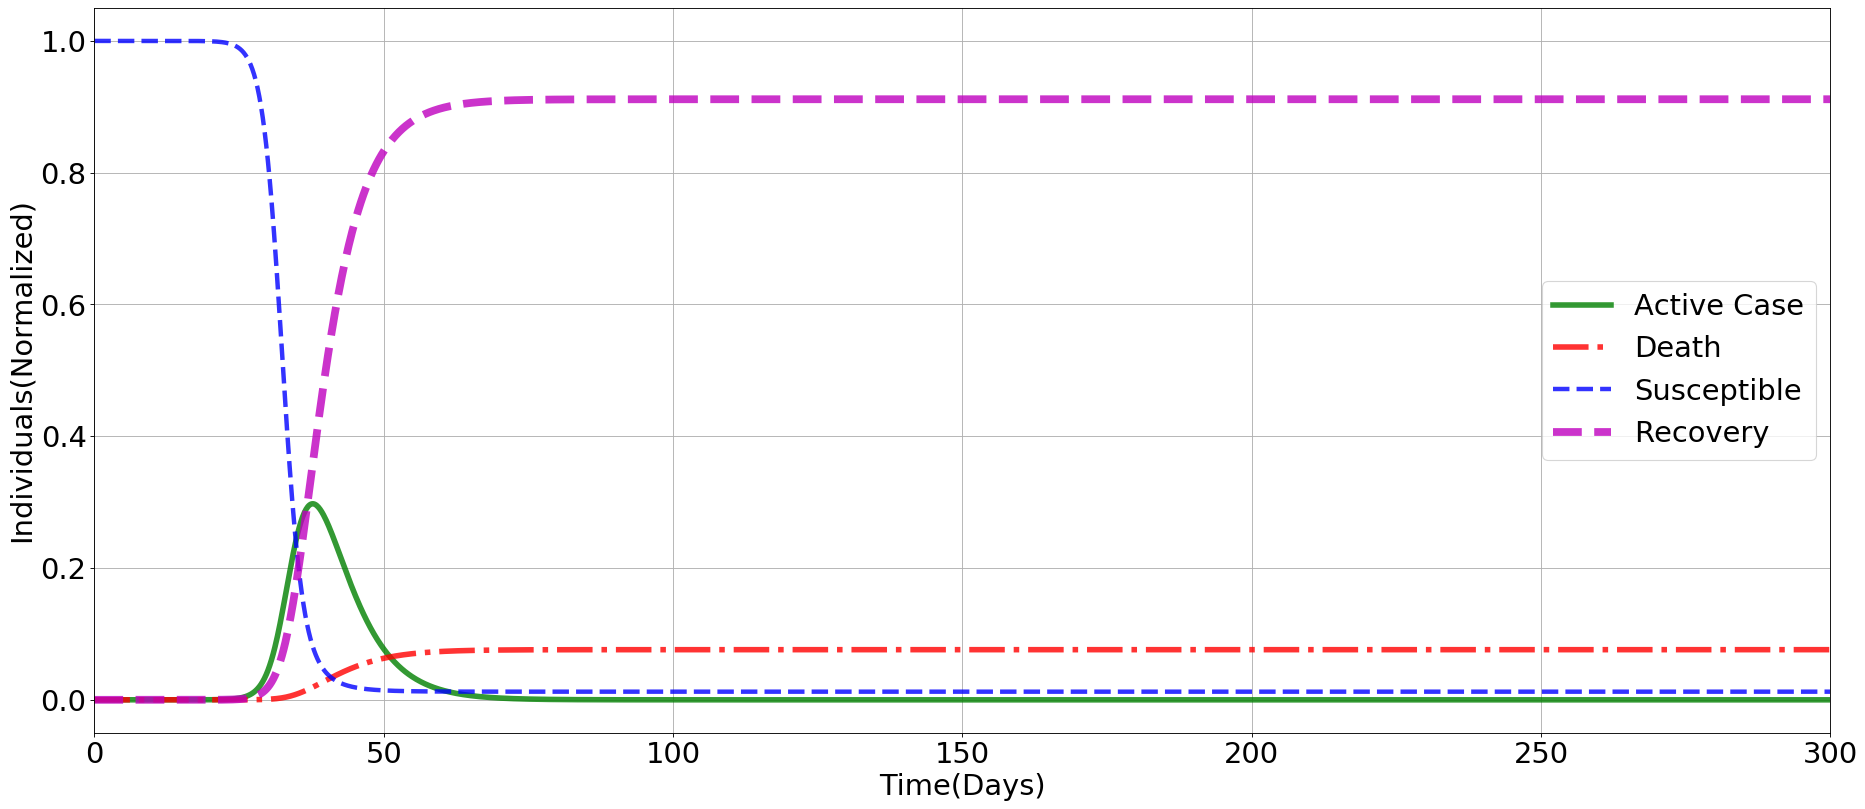

In [19]:
fig = plt.figure(num=None, figsize=(28, 12), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})
plt.plot(t, tempIs/N + tempIa/N , '-', lw=5, color='g', label='Active Case', alpha=0.8)
plt.plot(t, IC_death/N, '-.', lw=5, color='r', label='Death', alpha=0.8)
plt.plot(t, tempS/N, '--', lw=4, color='b', label='Susceptible', alpha=0.8)
plt.plot(t, tempR/N, '--', lw=7, color='m', label='Recovery', alpha=0.8)
#plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun','24Jun'));
dt = np.linspace(0,Tf,Nf)[1]
day = int(dt*100)
plt.legend(fontsize=26, loc='best'); plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Individuals(Normalized)');
#plt.xlim(0,100)
ymax = 1.9*1e9
save_results_to = 'C:/Users/HP/Desktop/Lat_radon/double peak/'
plt.xlabel('Time(Days)');
#plt.savefig(save_results_to+'sympt1.png',format='png',dpi=200)
#plt.savefig(save_results_to+'asymp_sympt1.png',format='png',dpi=200)